In [51]:
import sys
sys.path.append('../../')
sys.path.append('../')

from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

In [37]:
dHCP_participant_info = pd.read_table('../codes/FBA/dHCP_participant_info.csv')

In [38]:
dHCP_participant_info = dHCP_participant_info.rename(columns={'birth_age':'GA','scan_age':'PMA'})

In [39]:
dHCP_participant_info ['termness'] = genetic_file_preprocess.Cohort.get_termness(dHCP_participant_info)

In [40]:
dHCP_participant_info['participant_id'] = 'sub-' + dHCP_participant_info['participant_id']
dHCP_participant_info['session_id'] = 'ses-' + dHCP_participant_info['session_id'].astype('str')
dHCP_participant_info['particpant/session'] =  dHCP_participant_info['participant_id']+'/'+dHCP_participant_info['session_id']

In [6]:
! python ../codes/FBA/generate_ID_list.py generate --folder ../codes/FBA/data/ --pattern "sub*/ses*" --duplicates | python ../codes/FBA/generate_ID_list.py generate --folder ../codes/FBA/dhcp_neo_dMRI_derived/ --pattern "sub*/ses*" --no-duplicates | tail -n +3 | tr '/' ',' > ../codes/FBA/available_term_preterm.txt
# ! tr '/' ',' < ../codes/FBA/available_term_preterm.txt > ../codes/FBA/available_term_preterm.txt

In [41]:
available_dmri = pd.read_csv('../codes/FBA/available_term_preterm.txt',header=None,names=['participant_id','session_id'])

In [42]:
available_dmri['available_dmri'] = 'yes'

In [43]:
dHCP_participant_info = available_dmri.merge(dHCP_participant_info,on=['participant_id','session_id'],how='left')

In [44]:
to_exclude=["sub-CC00702BN09/ses-204500",
              "sub-CC00666XX15/ses-212100",
              "sub-CC00600XX06/ses-192200",
              "sub-CC00702AN09/ses-204600",
              "sub-CC00657XX14/ses-212200",
              "sub-CC00572BN12/ses-161400"]

In [45]:
dHCP_participant_info = dHCP_participant_info[~dHCP_participant_info['particpant/session'].isin(to_exclude)]

In [46]:
dHCP_participant_info = dHCP_participant_info[(dHCP_participant_info['termness']=='preterm/term_at_scan') | (dHCP_participant_info['termness']=='term')].copy()
dHCP_participant_info = dHCP_participant_info.drop_duplicates(subset='participant_id',keep='last').copy()

In [47]:
preterm, term = stats.Stability_tests.nn_matching(dHCP_participant_info,
                                                  cat_independentVar_cols=['sex'],
                                 cont_independentVar_cols=['PMA'],
                                  dependentVar_cols=['termness'],scaling=True,order='random',random_state=24)

In [48]:
dHCP_term_preterm = pd.concat([preterm,term])

<AxesSubplot:xlabel='GA', ylabel='Count'>

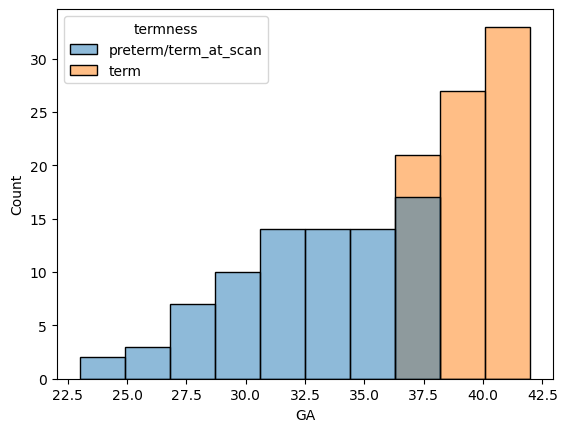

In [50]:
sns.histplot(data=dHCP_term_preterm,x='GA',hue='termness',bins=10)

In [ ]:
sns.histplot()

In [17]:
neonatal_volumes = pd.read_csv('../dataset/preprocessed_dataset/imaging_data/log_file/volumetric_dataset_neonatal_release_3.csv')
neonatal_volumes['participant_id'] = 'sub-' + neonatal_volumes['ID']
neonatal_volumes['session_id'] = 'ses-' + neonatal_volumes['Session'].astype('str')

In [20]:
dHCP_term_preterm = dHCP_term_preterm.merge(neonatal_volumes[['participant_id','session_id','ICV']],on=['participant_id','session_id'],how='inner')

In [26]:
dHCP_term_preterm[['particpant/session','GA','PMA','sex','termness','ICV','birth_weight']].to_csv('../codes/FBA/subject_lists_term_preterm.txt',header=None,index=False)

## Tractography

In [56]:
ROIs_coord_AAL = visualisation.Brainmap.get_ROIs_coordinates('../codes/FBA/test/test_tract/regrid_KANA_in_template_space.nii.gz')

In [61]:
ROIs_coord_AAL.iloc[[82,86]]

,Label,X_vox,Y_vox,Z_vox,X_sca,Y_sca,Z_sca
82,83.0,17.589812,56.167560,22.280161,-24.014493,-2.913433,-7.293608
86,87.0,19.016340,55.905229,16.503268,-22.160007,-3.254464,-14.803569


In [64]:
ROIs_coord_AAL.iloc[[8,14]].mean()

Label    12.000000
X_vox    22.603738
Y_vox    71.305588
Z_vox    26.540809
X_sca   -17.496390
Y_sca    16.766002
Z_sca    -1.754765
dtype: float64

In [ ]:
-24.18,-12.54,-4.63

In [ ]:
-17.5,19.31,3.469

In [40]:
ROIs_coord_AAL['Label'] = ROIs_coord_AAL['Label'].astype('int64')

In [10]:
ROIs_coord_AAL[ROIs_coord_AAL['Label'] == 9]

,Label,X_vox,Y_vox,Z_vox,X_sca,Y_sca,Z_sca
8,9.0,64.203451,197.721929,69.835632,-15.429524,22.829707,-1.590001


In [53]:
np.array([24,76,26]) *1.3 + np.array([-46.88,-75.93,-36.26]).T

array([-15.68,  22.87,  -2.46])

In [92]:
np.array([24,76,26,1]).T * np.array([[1.3,0,0,-46.88125],[0,1.3,0,-75.93125],[0,0,1.3,-36.257],[0,0,0,1]]).T

array([[ 3.120000e+01,  0.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  9.880000e+01,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  3.380000e+01,  0.000000e+00],
       [-1.125150e+03, -5.770775e+03, -9.426820e+02,  1.000000e+00]])

In [93]:
transform = np.array([[1.3,0,0,-46.88125],[0,1.3,0,-75.93125],[0,0,1.3,-36.257],[0,0,0,1]])

In [120]:
voxel=np.array([24,76,26,1])

In [122]:
np.matmul(transform[:-1,:],voxel)

array([-15.68125,  22.86875,  -2.457  ])

In [65]:
test = visualisation.Brainmap('../codes/FBA/test/test_tract/regrid_KANA_in_template_space.nii.gz')

In [89]:
test.atlas_file.affine[:-1,-1]

array([-46.881248  , -75.93125916, -36.25781631])

In [78]:
dir(test.atlas_file.header)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chk_bitpix',
 '_chk_datatype',
 '_chk_magic',
 '_chk_offset',
 '_chk_pixdims',
 '_chk_qfac',
 '_chk_qform_code',
 '_chk_sform_code',
 '_chk_sizeof_hdr',
 '_chk_xform_code',
 '_clean_after_mapping',
 '_data_type_codes',
 '_field_recoders',
 '_get_checks',
 '_slice_time_order',
 '_structarr',
 'as_analyze_map',
 'as_byteswapped',
 'binaryblock',
 'check_fix',
 'copy',
 'data_from_fileobj',
 'data_layout',
 'data_to_fileobj',
 'default_structarr',
 'default_x_flip',
 'diagnose_binaryblock',
 'endianness',
 'extensions',
 'exts_klass',
 'from_fileobj',
 'from_

In [11]:
brain_map = visualisation.Brainmap('../codes/FBA/test/test_tract/regrid_KANA_in_template_space.nii.gz')

In [12]:
brain_map.atlas[np.isnan(brain_map.atlas)] = 0 # if nan exist set to 0
transform_matrix = brain_map.atlas_file.affine[:-1,:]
ROIs_coord = defaultdict(list)
for label in np.unique(brain_map.atlas):
    if label != 0:
        ROIs_coord[label] = [coord.mean() for coord in np.where(brain_map.atlas == label)]
        ROIs_coord[label].extend(list(np.matmul(transform_matrix,np.array(ROIs_coord[label] + [1]))))

In [13]:
ROIs_coord[9]

[24.096638655462186,
 76.0266106442577,
 26.69327731092437,
 -15.555618894200364,
 22.90333105703027,
 -1.5565570833302331]

In [15]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../codes/FBA/test/test_tract/regrid_KANA_in_template_space.nii.gz')

In [17]:
ROIs_coord['Label'] = ROIs_coord['Label'].astype('int64')

In [18]:
ROIs_coord.to_csv('../codes/FBA/test/test_tract/ROIs_coord.txt',sep='\t',header=None,index=False)

In [1]:
import pandas as pd

In [18]:
cc_fdc = pd.read_csv('../codes/FBA/output_term_preterm/tractography/fba/all_subj_fdc_smooth/mean_cc.txt',header=None,names=['MeanFDC'])

In [19]:
design_matrix = pd.read_table('../codes/FBA/output_term_preterm/tractography/fba/design_matrix.txt',delim_whitespace=True)

In [21]:
design_matrix = pd.concat([design_matrix,cc_fdc],axis=1)

In [23]:
design_matrix

,#intercept,sex_female=1,termness_preterm/term_at_scan=1,PMA,ICV,MeanFDC
0,1,-1,1,-0.522116,-0.540728,0.458592
1,1,1,1,0.511738,1.110910,0.444781
2,1,1,1,1.477956,1.384596,0.488684
3,1,-1,1,0.579373,0.780190,0.482940
4,1,-1,1,1.134948,-0.325077,0.348040
...,...,...,...,...,...,...
157,1,1,-1,-1.280597,-1.578493,0.455303
158,1,-1,-1,1.477956,1.173707,0.626924
159,1,-1,-1,-1.145326,-1.242368,0.409103
160,1,1,-1,0.168730,-0.255715,0.563484


In [33]:
model_ICV,_ = stats.MassUnivariate.mass_univariate(df=design_matrix,
                                    cat_independentVar_cols=['sex_female=1','termness_preterm/term_at_scan=1'],
                                    cont_independentVar_cols=['ICV'],
                                    dependentVar_cols=['MeanFDC'])

In [36]:
np.corrcoef(design_matrix['PMA'],design_matrix['ICV'])

array([[1.        , 0.72525698],
       [0.72525698, 1.        ]])

In [35]:
model_ICV.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                MeanFDC   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     24.66
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           3.86e-13
Time:                        11:36:32   Log-Likelihood:                 202.86
No. Observations:                 162   AIC:                            -397.7
Df Residuals:                     158   BIC:                            -385.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.5071      0.009     58.524      0.000       0.490       0.524
ICV                                   0.0298      0.006      5.291      0.000       0.019       0.041
sex_female=1_1                    -8.365e-06      0.012     -0.001      0.999      -0.023       0.023
termness_preterm/term_at_scan=1_1    -0.0809      0.011     -7.260      0.000      -0.103      -0.059
==============================================================================
Omnibus:                       11.330   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.116
Skew:                          -0.503   Prob(JB):                      0.00142
Kurtosis:                       3.966   Cond. No.                         2.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
model_PMAonly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                MeanFDC   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     18.34
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           2.94e-10
Time:                        11:33:46   Log-Likelihood:                 195.95
No. Observations:                 162   AIC:                            -383.9
Df Residuals:                     158   BIC:                            -371.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.5078      0.009     56.149      0.000       0.490       0.526
PMA                                   0.0206      0.006      3.577      0.000       0.009       0.032
sex_female=1_1                       -0.0143      0.012     -1.198      0.233      -0.038       0.009
termness_preterm/term_at_scan=1_1    -0.0715      0.012     -6.207      0.000      -0.094      -0.049
==============================================================================
Omnibus:                        8.394   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.353
Skew:                          -0.473   Prob(JB):                       0.0154
Kurtosis:                       3.586   Cond. No.                         2.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
model_PMA_ICV.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                MeanFDC   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     18.45
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           1.90e-12
Time:                        11:34:11   Log-Likelihood:                 202.97
No. Observations:                 162   AIC:                            -395.9
Df Residuals:                     157   BIC:                            -380.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.5070      0.009     58.349      0.000       0.490       0.524
PMA                                  -0.0039      0.009     -0.459      0.647      -0.021       0.013
ICV                                   0.0329      0.009      3.769      0.000       0.016       0.050
sex_female=1_1                        0.0017      0.012      0.140      0.889      -0.022       0.026
termness_preterm/term_at_scan=1_1    -0.0820      0.011     -7.181      0.000      -0.105      -0.059
==============================================================================
Omnibus:                       12.048   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.174
Skew:                          -0.522   Prob(JB):                     0.000836
Kurtosis:                       4.005   Cond. No.                         3.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""